Refer to the 'ArXiv 1805.00794'

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, add, ReLU
from tensorflow.keras import Model
import matplotlib
import matplotlib.pyplot as plt


train_data = pd.read_csv("../input/heartbeat/mitbih_train.csv", header=None)
test_data = pd.read_csv("../input/heartbeat/mitbih_test.csv", header=None)



Processing Pandas dataframe to Numpy array

In [7]:
train_information = train_data.iloc[:, :-1].to_numpy()
train_label = train_data.iloc[:, -1].to_numpy()

test_information = test_data.iloc[:, :-1].to_numpy()
test_label = test_data.iloc[:, -1].to_numpy()

print(test_label)

[0. 0. 0. ... 4. 4. 4.]


**Add Gaussian noise to the dataset** It prevents dataset from overfitting

0.0


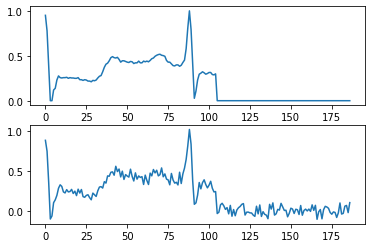

In [8]:
gaussian_flag = 0

def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,187)
    return (signal+noise)

tempo=train_information[20]
print(train_label[0])
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(tempo)

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

train_information = add_gaussian_noise(train_information)
gaussian_flag = not gaussian_flag

Add a channel for convolutional layer

In [9]:
train_information = train_information[..., tf.newaxis]
test_information = test_information[..., tf.newaxis]

print(train_information.shape)

(87554, 187, 1)


Batch the dataset to enhance performance

In [10]:
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_information, train_label)).shuffle(10000).batch(BATCH_SIZE )
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_information, test_label)).batch(BATCH_SIZE )

Construct the model by using Keras subclass API. This model is from the paper 'ArXiv 1805.00794'

In [11]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv_in = Conv1D(32, input_shape=(None, 187, 1), kernel_size=(5), strides=1,
                              padding='same', activation='relu')
        self.conv_relu = Conv1D(32, kernel_size=(5), strides=1,
                           padding='same', activation='relu')
        self.conv_raw = Conv1D(32, kernel_size=(5), strides=1,
                              padding='same')
        self.maxpool = MaxPooling1D(pool_size=5, strides=2)
        self.flatten = Flatten()
        self.relu = ReLU()
        self.dense = Dense(32, activation='relu')
        self.dense_out = Dense(5, activation='softmax')

    def routine(self, x):
        input_param = x
        x = self.conv_relu(x)
        x = self.conv_raw(x)
        x = add([input_param, x])
        x = self.relu(x)
        return self.maxpool(x)

    def call(self, x):
        x = self.conv_in(x)
        for _ in range(5):
            x = self.routine(x)

        x = self.flatten(x)

        x = self.dense(x)
        return self.dense_out(x)

Set Loss function & Optimizer and training & test sequence.

In [12]:
model = MyModel()

# Loss Func. SCC
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Opimizer Adam
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

Let's get it started.

In [13]:
EPOCHS = 75

train_loss_results = []
train_accuracy_results = []

test_loss_results = []
test_accuracy_results = []


for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    train_loss_results.append(train_loss.result())
    train_accuracy_results.append(train_accuracy.result())

    test_loss_results.append(test_loss.result())
    test_accuracy_results.append(test_accuracy.result())

    template = 'EPOCH: {}, LOSS: {}, ACCURACY: {}, TEST LOSS: {}, TEST ACCURACY: {}'
    if (epoch + 1) % 5 == 0:
        print(template.format(epoch + 1,
                              train_loss.result(),
                              train_accuracy.result() * 100,
                              test_loss.result(),
                              test_accuracy.result() * 100))

EPOCH: 5, LOSS: 0.1042962595820427, ACCURACY: 96.4515609741211, TEST LOSS: 0.33231839537620544, TEST ACCURACY: 89.8675308227539
EPOCH: 10, LOSS: 0.07568305730819702, ACCURACY: 97.45128631591797, TEST LOSS: 0.2601624131202698, TEST ACCURACY: 92.15101623535156
EPOCH: 15, LOSS: 0.06314744800329208, ACCURACY: 97.88138580322266, TEST LOSS: 0.23116035759449005, TEST ACCURACY: 93.02180480957031
EPOCH: 20, LOSS: 0.05568952485918999, ACCURACY: 98.13520812988281, TEST LOSS: 0.22065244615077972, TEST ACCURACY: 93.2386245727539
EPOCH: 25, LOSS: 0.05091695487499237, ACCURACY: 98.2956314086914, TEST LOSS: 0.21411387622356415, TEST ACCURACY: 93.40032958984375
EPOCH: 30, LOSS: 0.04723694920539856, ACCURACY: 98.41804504394531, TEST LOSS: 0.2088114321231842, TEST ACCURACY: 93.54802703857422
EPOCH: 35, LOSS: 0.04443616047501564, ACCURACY: 98.50994873046875, TEST LOSS: 0.2066909223794937, TEST ACCURACY: 93.57965087890625
EPOCH: 40, LOSS: 0.04213268309831619, ACCURACY: 98.58635711669922, TEST LOSS: 0.20372

Visual results.

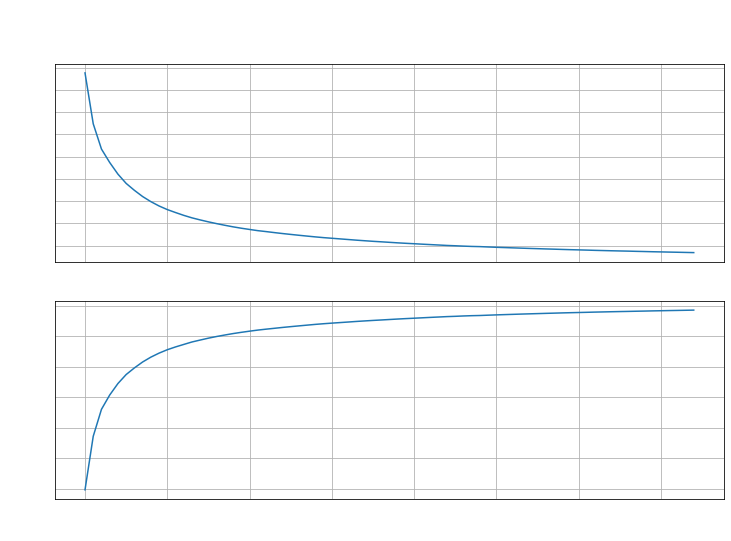

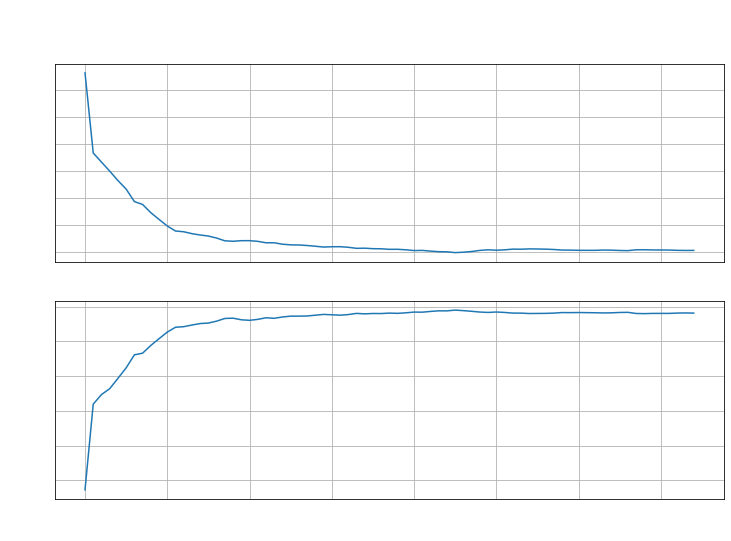

In [14]:
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Results', fontsize=20)

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)
axes[0].grid()

axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].plot(train_accuracy_results)
axes[1].grid()


fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Test Results', fontsize=20)

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(test_loss_results)
axes[0].grid()

axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].plot(test_accuracy_results)
axes[1].grid()

plt.show()